In [1]:
import torch
import torchvision
import time
import random
import math
import json

from PIL import Image, ImageFont, ImageDraw

In [2]:
alphabet = ['*','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
random.seed(100)
alphabetColors = [(random.randrange(256),random.randrange(256),random.randrange(256)) for i in alphabet]
def displayCoords(image, coords, labels):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for i in range(len(coords)):
        coord = coords[i]
        label = labels[i]
        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[2]
        y2 = coord[3]
        color = alphabetColors[label]
        
        draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
        draw.text((x1+2,y1), alphabet[label], color, font=font)
        
    display(imageCopy)

def displayGroups(image, results, groupsIndices):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for g in groupsIndices:
        for i in results['groups'][g]:
            coord = results['boxes'][i]
            label = results['labels'][i]
            x1 = coord[0]
            y1 = coord[1]
            x2 = coord[2]
            y2 = coord[3]
            color = alphabetColors[label]

            draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
            draw.text((x1+2,y1), alphabet[label], color, font=font)
        
    display(imageCopy)

In [3]:
evalModel = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=None,
    num_classes=27,
    box_detections_per_img=2000
)
evalModel.eval()
evalModel.load_state_dict(torch.load("./Models/SoulGlyph_Mobile_Model_V16.pth"))

<All keys matched successfully>

In [21]:
def sortResults(result):
    
    indices = result['scores'].argsort(dim=0, descending=True)
    indices4 = indices.repeat(4,1).transpose(1,0)
    
    result2 = {'groups':[], 'neighbors':[]}
    
    result2['boxes'] = result['boxes'].gather(index=indices4,dim=0)
    result2['labels'] = result['labels'].gather(index=indices,dim=0)
    result2['scores'] = result['scores'].gather(index=indices,dim=0)
    
    indicesList = indices.tolist()
    indicesReverse = {str(indicesList[i]):i for i in range(len(indicesList))}
    for group in result['groups']:
        #result2['groups'].append([indicesList[i] for i in group])
        result2['groups'].append([indicesReverse[str(i)] for i in group])
        
    for neighborsGroup in result['neighbors']:
        #result2['neighbors'].append([indicesList[i] for i in neighborsGroup])
        result2['neighbors'].append([indicesReverse[str(i)] for i in neighborsGroup])
    
    return result2

def vizTensor(tensor):
    T = torchvision.transforms.ToPILImage()
    display(T(tensor))

def filterResults(result, min_score):
    i = 0
    while i < len(result['scores']) and result['scores'][i] > min_score:
        i+=1
        
    result['boxes'] = result['boxes'][:i]
    result['labels'] = result['labels'][:i]
    result['scores'] = result['scores'][:i]
    
    for j,group in enumerate(result['groups']):
        result['groups'][j] = [n for n in group if n<i]
        
    for j,neighborsGroup in enumerate(result['neighbors']):
        result['neighbors'][j] = [n for n in neighborsGroup if n<i]

def resultsToLists(result):
    result['boxes'] = result['boxes'].tolist()
    result['labels'] = result['labels'].tolist()
    result['scores'] = result['scores'].tolist()
    
def computeNeighbors(result,nX,nY):
    nGroups = nX*nY
    result['neighbors'] = [[] for i in range(nGroups+1)] #adds self as neighbors for the full-sized group
    
    result['neighbors'][nGroups].extend(result['groups'][nGroups])
    
    for x in range(nX):
        for y in range(nY):
            
            group = (x*nY+y)
            
            result['neighbors'][group].extend(result['groups'][group])
            if x>0:
                result['neighbors'][group].extend(result['groups'][(x-1)*nY+y])
                if y>0:
                    result['neighbors'][group].extend(result['groups'][x*nY+(y-1)])
                    result['neighbors'][group].extend(result['groups'][(x-1)*nY+(y-1)])
            elif y>0:
                result['neighbors'][group].extend(result['groups'][x*nY+(y-1)])
                    
            
            if x<nX-1:
                result['neighbors'][group].extend(result['groups'][(x+1)*nY+y])
                if y<nY-1:
                    result['neighbors'][group].extend(result['groups'][x*nY+(y+1)])
                    result['neighbors'][group].extend(result['groups'][(x+1)*nY+(y+1)])  
            elif y<nY-1:
                result['neighbors'][group].extend(result['groups'][x*nY+(y+1)])
                
            if x<nX-1 and y>0:
                result['neighbors'][group].extend(result['groups'][(x+1)*nY+(y-1)])
                
            if y<nY-1 and x>0:
                result['neighbors'][group].extend(result['groups'][(x-1)*nY+(y+1)])
                
            result['neighbors'][nGroups].extend(result['groups'][group]) #adds all previous groups as neighbors for the full-sized group
                
    
                

def applySubPicture(model,tensor,x1=0,y1=0,w1=None,h1=None,w2=None,h2=None):
    if w1 is None or w2 is None or h1 is None or h2 is None:
        w1,h1 = tensor.shape[-2:]
        w2,h2 = tensor.shape[-2:]
    
    resize = torchvision.transforms.Resize((w2,h2), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
    xmod = w1/w2
    ymod = h1/h2
    
    tensor_resized = resize(tensor[:,y1:y1+h1,x1:x1+w1])
    #vizTensor(tensor_resized)
    result = model([tensor_resized])
    for i in range(len(result[0]['boxes'])):
        result[0]['boxes'][i][0] = result[0]['boxes'][i][0]*xmod + x1
        result[0]['boxes'][i][1] = result[0]['boxes'][i][1]*ymod + y1
        result[0]['boxes'][i][2] = result[0]['boxes'][i][2]*xmod + x1
        result[0]['boxes'][i][3] = result[0]['boxes'][i][3]*ymod + y1
    
    return result

def getOverlap(rect1, rect2) -> float:
    
    x1,y1,x1_,y1_ = rect1
    x2,y2,x2_,y2_ = rect2
    
    dx = min(x1_,x2_)-max(x1,x2)
    dy = min(y1_,y2_)-max(y1,y2)
    
    isOverlapp = int(dx>0 and dy>0)
    area = isOverlapp*dx*dy
    
    return area

def getArea(rect) -> float:
    return (rect[2]-rect[0])*(rect[3]-rect[1])

def removeOverlaps(results) -> dict:
    commonGroundThreshold = 0.3
    containementThreshold = 0.3
    
    scoreIgnoreThreshold = 0.5
    
    indicesToRemove = set()
    for neighborGroup in results['neighbors']:
        for i in neighborGroup:
            for j in neighborGroup:
                if(i in indicesToRemove or j in indicesToRemove or i==j):
                    continue
                
                box1 = results['boxes'][i]
                box2 = results['boxes'][j]

                intersection = getOverlap(box1,box2)
                a1 = getArea(box1)
                a2 = getArea(box2)
                union = a1 + a2 - intersection

                isContained = intersection/a1 > containementThreshold or intersection/a2 > containementThreshold
                isOverlap = intersection/union > commonGroundThreshold
                #ignoreOverlap = min(results['scores'][i],results['scores'][j])>scoreIgnoreThreshold
                #ignoreOverlap = results['scores'][i]>intersection/a1 and results['scores'][j] > intersection/a2
                ignoreOverlap = False

                if (isOverlap or isContained) and not ignoreOverlap:
                    indexMin = min(i,j,key=(lambda a : results['scores'][a]))
                    indicesToRemove.add(indexMin)
    
    listIndicesToRemove = list(indicesToRemove)
    listIndicesToRemove.sort(reverse=True)
    """
    for index in listIndicesToRemove:
        del results['scores'][index]
        del results['boxes'][index]
        del results['labels'][index]
    """
    results['groups'] = [[j for j in i if j not in indicesToRemove] for i in results['groups']]
    results['neighbors'] = [[j for j in i if j not in indicesToRemove] for i in results['neighbors']]
            
        

In [47]:
with open('targets.json', 'r', encoding="utf-8") as f:
    image_nb = 4654
    #image_nb = 1956
    #image_nb = 1944
    infos = json.load(f)
    #test_img = Image.open(infos[image_nb]['image'])
    test_img = Image.open("./Examples/Poem.PNG") #big test
    #test_img = Image.open("./Examples/Envoys.PNG")
    
avgPicSize = (test_img.size[0]+test_img.size[1])//2
nCover = 2 #nb of times an area is covered
increment = 80
sampleSize = increment*nCover #avgPicSize//6

scaledSize = 800
w,h = test_img.size
nX = nCover*(w//sampleSize + int(bool(w%sampleSize))) - 1
nY = nCover*(h//sampleSize + int(bool(h%sampleSize))) - 1

to_tensor = torchvision.transforms.ToTensor()
pad = torch.nn.ZeroPad2d((0,sampleSize-(w+1)%sampleSize,0,sampleSize-(w+1)%sampleSize))
test_tensor = to_tensor(test_img)[:3]
test_tensor = pad(test_tensor)
#vizTensor(test_tensor)

#result = applySubPicture(evalModel,test_tensor)
nGroups = (nX*nY)
#print(nGroups)
full_results = {'boxes':torch.zeros(0,4), 'labels':torch.zeros(0).long(), 'scores':torch.zeros(0), 'groups':[[] for i in range(nGroups+1)]}


#sectionning
for x in range(nX):
    for y in range(nY):
        group = (x*nY+y)
        
        result = applySubPicture(evalModel,test_tensor, x1=x*increment,y1=y*increment, w1=sampleSize,h1=sampleSize, w2=scaledSize,h2=scaledSize)
        full_results['groups'][group] = [i for i in range(full_results['scores'].size(0), full_results['scores'].size(0)+result[0]['scores'].size(0))]
        full_results['boxes'] = torch.cat([full_results['boxes'],result[0]['boxes']] , dim=0)
        full_results['labels'] = torch.cat([full_results['labels'],result[0]['labels']], dim=0)
        full_results['scores'] = torch.cat([full_results['scores'],result[0]['scores']], dim=0)
        

        print(str(100*group//nGroups) + "% complete")
        


#full-sized group
if nGroups < 9:
    for group in [nGroups]:
        w = test_img.size[0]
        h = test_img.size[1]
        result = applySubPicture(evalModel,test_tensor, x1=0,y1=0, w1=w,h1=h, w2=w,h2=h)
        full_results['groups'][group] = [i for i in range(full_results['scores'].size(0), full_results['scores'].size(0)+result[0]['scores'].size(0))]
        full_results['boxes'] = torch.cat([full_results['boxes'],result[0]['boxes']] , dim=0)
        full_results['labels'] = torch.cat([full_results['labels'],result[0]['labels']], dim=0)
        full_results['scores'] = torch.cat([full_results['scores'],result[0]['scores']], dim=0)
    
#full_results['neighbors'] = [[]]*nGroups
print("100% complete")
    
    
    

0% complete
0% complete
1% complete
1% complete
2% complete
2% complete
3% complete
3% complete
4% complete
4% complete
5% complete
5% complete
6% complete
6% complete
7% complete
7% complete
8% complete
8% complete
9% complete
9% complete
10% complete
10% complete
11% complete
11% complete
12% complete
12% complete
13% complete
13% complete
14% complete
14% complete
15% complete
15% complete
16% complete
16% complete
17% complete
17% complete
18% complete
18% complete
19% complete
20% complete
20% complete
21% complete
21% complete
22% complete
22% complete
23% complete
23% complete
24% complete
24% complete
25% complete
25% complete
26% complete
26% complete
27% complete
27% complete
28% complete
28% complete
29% complete
29% complete
30% complete
30% complete
31% complete
31% complete
32% complete
32% complete
33% complete
33% complete
34% complete
34% complete
35% complete
35% complete
36% complete
36% complete
37% complete
37% complete
38% complete
38% complete
39% complete
40% co

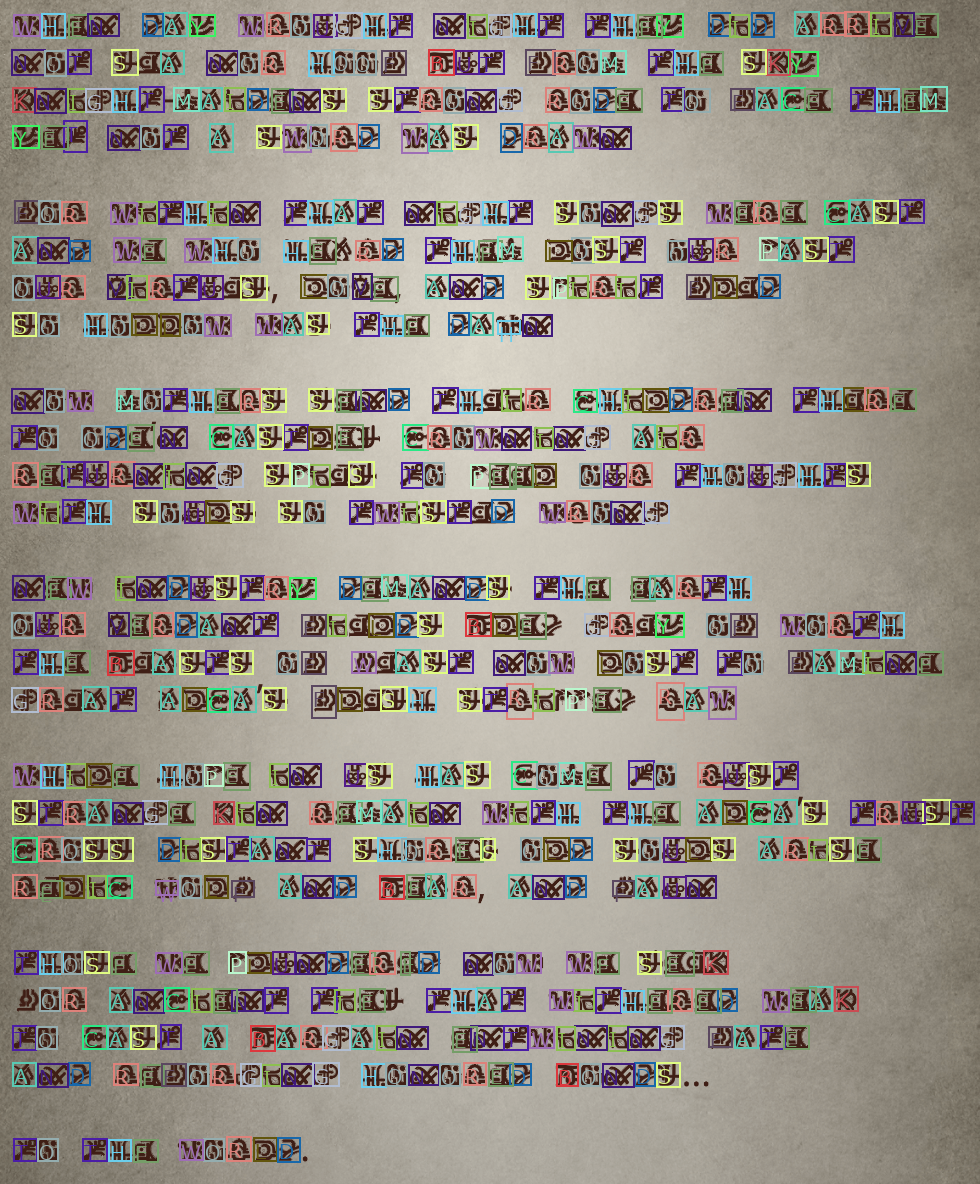

In [55]:
filterThreshold = 0.3

computeNeighbors(full_results,nX,nY)
mod_results = sortResults(full_results)
filterResults(mod_results,filterThreshold)
resultsToLists(mod_results)
#print(mod_results['groups'])
#print(mod_results['neighbors'])
#print(sum([len(i) for i in mod_results['groups']]))
#print(sum([len(i) for i in mod_results['neighbors']]))
#print(sum([len(i) for i in mod_results['groups']]))
removeOverlaps(mod_results)
#print(sum([len(i) for i in mod_results['groups']]))
#print(mod_results['groups'])
#displayCoords(test_img, mod_results['boxes'], mod_results['labels'])
displayGroups(test_img, mod_results, [i for i in range(nGroups+1)])
#displayGroups(test_img, mod_results, [77,78,88,89])
#print(mod_results['groups'])

#print(len(full_results['boxes']))
#print(full_results['labels'])
#print(full_results['scores'])